Map:   0%|          | 0/88 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.132035
2,0.135300,0.132894
3,0.135400,0.133609
4,0.104800,0.134129
5,0.102100,0.135349
6,0.122200,0.135598
7,0.124700,0.136261
8,0.117900,0.136395
9,0.108900,0.135949
10,0.098500,0.136215


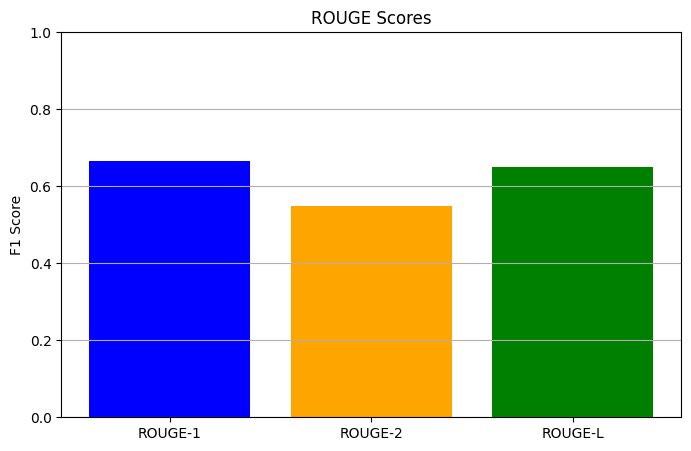

In [6]:
import torch
from datasets import load_dataset
from transformers import MT5ForConditionalGeneration, MT5Tokenizer, Trainer, TrainingArguments
import evaluate
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and tokenizer
model_name = "fine_tuned_savasy/mt5-mlsum-turkish-summarization"
model = MT5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = MT5Tokenizer.from_pretrained(model_name, model_max_length=512)

model.to(device)

# 1. Load the dataset in JSON format
def load_custom_dataset(json_file):
    dataset = load_dataset('json', data_files=json_file)
    return dataset

# 2. Data processing (Tokenization)
def preprocess_function(examples):
    inputs = examples['input_text']
    targets = examples['output_text']
    
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Load and prepare the dataset
dataset = load_custom_dataset("findProdName-io.json")
tokenized_datasets = dataset.map(preprocess_function, batched=True)

# 3. Split into training and validation datasets
train_test_split = tokenized_datasets["train"].train_test_split(test_size=0.2)
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]

# 4. Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=2,
)

# 5. Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
)

# 6. Start training
trainer.train()

# 7. Load the ROUGE metric
rouge_metric = evaluate.load("rouge")

# 8. Model evaluation (corrected version)
def evaluate_model():
    model.eval()  # Set model to evaluation mode
    predictions = []
    references = []
    
    # Evaluate in batches to avoid mismatch issues
    for i in range(0, len(eval_dataset), training_args.per_device_eval_batch_size):
        batch = eval_dataset[i:i + training_args.per_device_eval_batch_size]
        
        inputs = tokenizer(batch['input_text'], return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            output_sequences = model.generate(input_ids=inputs["input_ids"], max_new_tokens=50)
        
        # Store outputs and references
        predicted_texts = [tokenizer.decode(seq, skip_special_tokens=True) for seq in output_sequences]
        references.extend(batch['output_text'])  # Actual texts
        predictions.extend(predicted_texts)  # Model predictions
    
    # Check if predictions and references match in length
    if len(predictions) != len(references):
        print(f"Warning: Mismatch in predictions ({len(predictions)}) and references ({len(references)}).")
        references = references[:len(predictions)]  # Adjust references length to match predictions
    
    # Calculate ROUGE score
    results = rouge_metric.compute(predictions=predictions, references=references)
    
    # ROUGE scores directly
    rouge_scores = {
        "ROUGE-1": results["rouge1"],
        "ROUGE-2": results["rouge2"],
        "ROUGE-L": results["rougeL"]
    }
    
    # Plot the scores
    plt.figure(figsize=(8, 5))
    plt.bar(rouge_scores.keys(), [rouge_scores[score] for score in rouge_scores], 
            color=['blue', 'orange', 'green'])
    plt.ylim(0, 1)
    plt.ylabel('F1 Score')
    plt.title('ROUGE Scores')
    plt.grid(axis='y')
    plt.show()

# Call the evaluation function
evaluate_model()


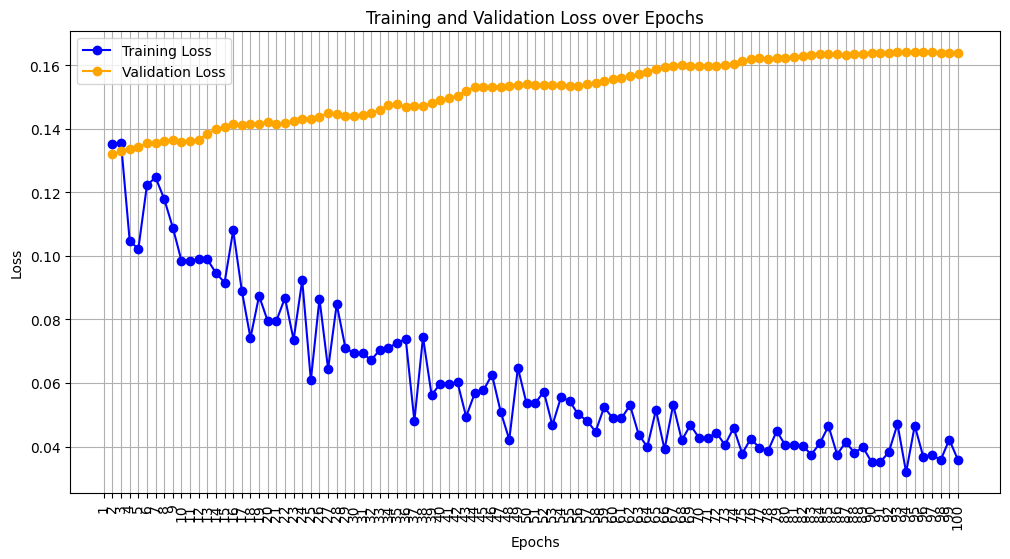

In [9]:
# Defining the training loss values provided
train_loss = [
    0.135300, 0.135400, 0.104800, 0.102100, 0.122200, 0.124700, 
    0.117900, 0.108900, 0.098500, 0.098500, 0.099100, 0.098900, 
    0.094600, 0.091600, 0.108000, 0.089000, 0.074200, 0.087400, 
    0.079500, 0.079500, 0.086800, 0.073600, 0.092300, 0.060900, 
    0.086500, 0.064400, 0.084800, 0.071100, 0.069300, 0.069300, 
    0.067200, 0.070500, 0.071000, 0.072700, 0.073800, 0.048100, 
    0.074400, 0.056200, 0.059800, 0.059800, 0.060200, 0.049400, 
    0.056800, 0.057700, 0.062600, 0.051000, 0.042200, 0.064800, 
    0.053600, 0.053600, 0.057300, 0.046700, 0.055600, 0.054300, 
    0.050100, 0.048200, 0.044700, 0.052400, 0.048900, 0.048900, 
    0.053000, 0.043800, 0.039900, 0.051500, 0.039100, 0.053200, 
    0.042000, 0.046800, 0.042700, 0.042700, 0.044400, 0.040500, 
    0.045900, 0.037800, 0.042500, 0.039600, 0.038700, 0.044900, 
    0.040400, 0.040400, 0.040300, 0.037500, 0.041000, 0.046500, 
    0.037500, 0.041400, 0.038100, 0.039800, 0.035100, 0.035100, 
    0.038300, 0.047100, 0.031900, 0.046600, 0.036700, 0.037500, 
    0.035700, 0.042200, 0.035900
]

# Using the same validation loss values
val_loss = [
    0.132035,
    0.132894, 0.133609, 0.134129, 0.135349, 0.135598, 0.136261, 
    0.136395, 0.135949, 0.136215, 0.136478, 0.138439, 0.139759, 
    0.140684, 0.141373, 0.141258, 0.141598, 0.141616, 0.142122, 
    0.141347, 0.141713, 0.142319, 0.143131, 0.143179, 0.143777, 
    0.144862, 0.144735, 0.144145, 0.144131, 0.144453, 0.144973, 
    0.145921, 0.147389, 0.147789, 0.146751, 0.147193, 0.147187, 
    0.147923, 0.149011, 0.149520, 0.150383, 0.151963, 0.153009, 
    0.153109, 0.153230, 0.153187, 0.153428, 0.153736, 0.153975, 
    0.153774, 0.153629, 0.153822, 0.153746, 0.153505, 0.153578, 
    0.153993, 0.154442, 0.154990, 0.155593, 0.156037, 0.156651, 
    0.157137, 0.157749, 0.158779, 0.159436, 0.159618, 0.160036, 
    0.159837, 0.159800, 0.159871, 0.159803, 0.160187, 0.160332, 
    0.161317, 0.161969, 0.162140, 0.162068, 0.162310, 0.162379, 
    0.162692, 0.162956, 0.163243, 0.163459, 0.163336, 0.163366, 
    0.163331, 0.163577, 0.163646, 0.163736, 0.163884, 0.163926, 
    0.163965, 0.164010, 0.163963, 0.163968, 0.163971, 0.163931, 
    0.163918, 0.163912
]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(range(1, 101), [None] + train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(range(1, 101), [None] + val_loss, label='Validation Loss', color='orange', marker='o')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, 101), rotation=90)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.legend()
plt.show()
